<a href="https://colab.research.google.com/github/inesbsilveira/hummingbirds/blob/main/wildfires_risk_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap
!pip install geojson

In [8]:
import os
import csv
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.validation import make_valid
import geojson
import zipfile
import ee
import geemap
from shapely.geometry import mapping
import time

In [3]:
my_project = 'ee-ineshummingbirds'
ee.Authenticate()
ee.Initialize(project= my_project)

In [54]:

# if the input is a shapefile
country = 'Ivory Coast'
project_area_name = 'Calao' #region/country/project name
input_shp = "cambodia_shp_joined_dissolved.shp"
gdf = gpd.read_file(input_shp).to_crs('EPSG:4326')
File = geemap.geopandas_to_ee(gdf)

In [68]:

# Define the date range
start_date = '2000-01-01'
end_date = '2022-12-31'
startDate = ee.Date(start_date)
endDate = ee.Date(end_date)

# Calculate the number of years to process
nYears = ee.Number(endDate.difference(startDate, 'year')).round().subtract(1)
print(f'Number of years: {nYears.getInfo()}')

# Load MODIS Burned Area dataset
sst = ee.ImageCollection("MODIS/006/MCD64A1") \
            .select('BurnDate') \
            .filterDate(startDate, endDate)

# Create a function to process burned area by year
def process_year(n):
    # Calculate the start and end date for each year
    ini = startDate.advance(n, 'year')
    end = ini.advance(1, 'year')

    # Filter the burned area collection for the given year
    result = sst.filterDate(ini, end)
    result = result.max().set('system:time_start', ini)

    # Get the burned area (where BurnDate is not 0) and mask it
    result = ee.Image.pixelArea() \
               .divide(10000) \
               .updateMask(result.neq(0))  # Mask out non-burned areas

    # Sum the area of burned forest for the year
    result = result.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=File,  # Use the converted region geometry
        scale=500,
        maxPixels=1e12,
        tileScale=4
    )

    # Extract the area burned in the forest for that year
    burnedArea = result.get('area')

    # Return the area burned in the forest for that year
    return ee.Feature(None, {'burned_area_ha': burnedArea})

# Map over each year and process the burned area
byYear = ee.FeatureCollection(
    ee.List.sequence(0, nYears).map(process_year)
)

# Print the results
print('Area (ha) burned forest by year:')
print(byYear.getInfo())


Number of years: 22
Area (ha) burned forest by year:
{'type': 'FeatureCollection', 'columns': {'burned_area_ha': 'Float', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': None, 'id': '0', 'properties': {'burned_area_ha': 458.434875}}, {'type': 'Feature', 'geometry': None, 'id': '1', 'properties': {'burned_area_ha': 902.8027759620096}}, {'type': 'Feature', 'geometry': None, 'id': '2', 'properties': {'burned_area_ha': 4964.247481158094}}, {'type': 'Feature', 'geometry': None, 'id': '3', 'properties': {'burned_area_ha': 4240.974049485296}}, {'type': 'Feature', 'geometry': None, 'id': '4', 'properties': {'burned_area_ha': 4859.404936397061}}, {'type': 'Feature', 'geometry': None, 'id': '5', 'properties': {'burned_area_ha': 3686.64208378064}}, {'type': 'Feature', 'geometry': None, 'id': '6', 'properties': {'burned_area_ha': 4604.053160514706}}, {'type': 'Feature', 'geometry': None, 'id': '7', 'properties': {'burned_area_ha': 6178.740329454653}}, {'type': 'Feature', 'g

In [69]:
# Extract the features from the Earth Engine FeatureCollection
features = byYear.getInfo()['features']

# Extract 'area_ha' values and their corresponding years
data = []
for feature in features:
    year = feature['id']  # The id corresponds to the year index (0-9 in your case)
    area_ha = feature['properties']['burned_area_ha']
    data.append({'year': int(year), 'burned_area_ha': area_ha})

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


    year  burned_area_ha
0      0      458.434875
1      1      902.802776
2      2     4964.247481
3      3     4240.974049
4      4     4859.404936
5      5     3686.642084
6      6     4604.053161
7      7     6178.740329
8      8     7105.998279
9      9     6279.075145
10    10     6300.126893
11    11     5591.854308
12    12     5925.298251
13    13     4174.810595
14    14     5226.258065
15    15     3969.394312
16    16     4082.686214
17    17     4444.870938
18    18     4226.462623
19    19     5669.192162
20    20     5584.554133
21    21     8288.136670
22    22     6341.851176


In [47]:
def get_shapefile_centroid(gdf):
    """Ensure CRS is geographic and return the centroid coordinates."""
    if gdf.crs is None or gdf.crs.is_projected:
        gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)

    centroid = gdf.unary_union.centroid
    return centroid.y, centroid.x  # (latitude, longitude)

def get_best_crs(latitude, longitude):
    """ Returns the best UTM zone EPSG code based on latitude """
    utm_zone = int((180 + longitude) / 6) + 1
    return f"EPSG:{32600 + utm_zone if latitude >= 0 else 32700 + utm_zone}"

In [57]:
latitude, longitude = get_shapefile_centroid(gdf)
#print(f"Central Point: ({latitude}, {longitude})")
best_epsg = get_best_crs(latitude, longitude)  # Replace with actual latitude
print(best_epsg)

EPSG:32648


<ipython-input-47-8622922bd85d>:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid


In [58]:
gdf_crs = gdf.to_crs(best_epsg)
total_area_ha = (gdf_crs['geometry'].area/10000).sum()
print(f"Total area in hectares: {total_area_ha}")

Total area in hectares: 16063.192346372653


In [70]:
# Add a new column to the DataFrame that represents the percentage of burned area
df['burned_area_percentage'] = (df['burned_area_ha'] / total_area_ha) * 100

# Display the updated DataFrame
print(df)

    year  burned_area_ha  burned_area_percentage
0      0      458.434875                2.853946
1      1      902.802776                5.620320
2      2     4964.247481               30.904489
3      3     4240.974049               26.401813
4      4     4859.404936               30.251801
5      5     3686.642084               22.950868
6      6     4604.053161               28.662131
7      7     6178.740329               38.465208
8      8     7105.998279               44.237771
9      9     6279.075145               39.089834
10    10     6300.126893               39.220889
11    11     5591.854308               34.811600
12    12     5925.298251               36.887426
13    13     4174.810595               25.989918
14    14     5226.258065               32.535613
15    15     3969.394312               24.711117
16    16     4082.686214               25.416406
17    17     4444.870938               27.671156
18    18     4226.462623               26.311474
19    19     5669.19

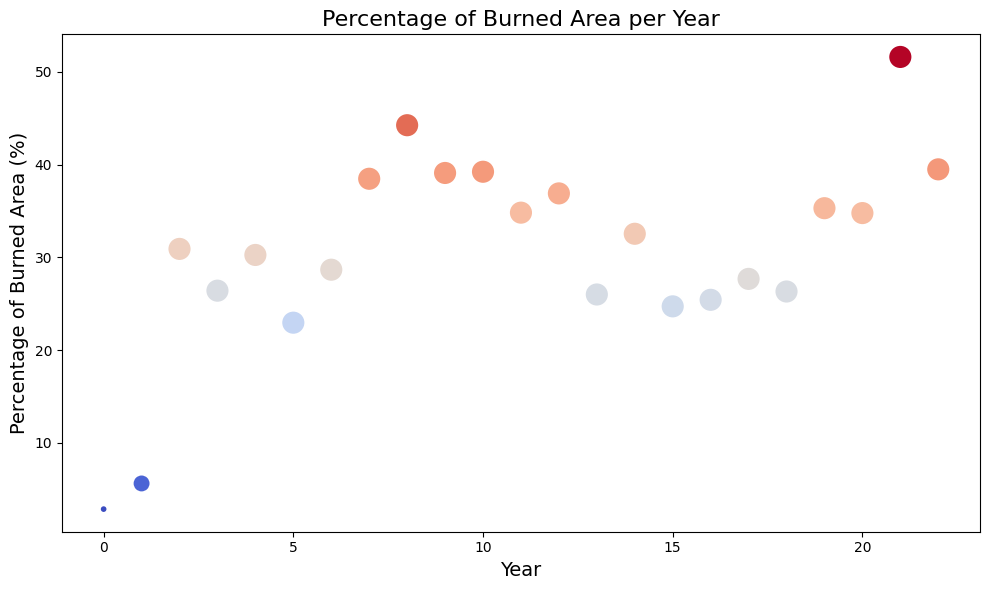

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' contains the 'year', 'percentage_burned', and 'area_burned(ha)' columns
# Categorize the point sizes based on the area burned
def size_category(area):
    if area < 300:
        return 30  # Small
    elif 300 <= area < 500:
        return 100  # Medium
    elif 500 <= area < 1000:
        return 200  # Medium-large
    else:
        return 300  # Large

# Apply the size category function to the 'area_burned(ha)' column
df['point_size'] = df['burned_area_ha'].apply(size_category)

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='year', y='burned_area_percentage', size='point_size', sizes=(30, 300), hue='burned_area_percentage', palette='coolwarm', legend=False)

# Set the labels and title
plt.title('Percentage of Burned Area per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage of Burned Area (%)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()
